<a href="https://colab.research.google.com/github/Mohamed-derbeli/ML-for-maximum-power-point-tracking-prediction-in-PV-system/blob/main/ML_for_MPPT_prediction_in_PV_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Machine Learning network for a commercial SG340P photovoltaic power prediction using different environmental data of Vitoria-Gasteiz, Spain. **



Explanation of this project can be found in https://www.mdpi.com/1996-1073/14/22/7806

This notebook does the following:

* **Read data from IBM db2 database.** 
* **Load data into dataframes.**
* **Clean & visuolize the data.**
* **Filter the data.**
* **Extract the maximum power points.**
* **Apply statistics.**
* **Training.**

In [1]:
# Installing required packages

!pip install pyspark
!pip install findspark
import findspark
findspark.init()

!pip install sqlalchemy==1.3.9
!pip install ibm_db_sa==0.3.7

In [2]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import models, layers, optimizers
# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split
# import urllib.request
# from sklearn import datasets



import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
from scipy.signal import butter,filtfilt
from google.colab import files



import sys
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.regression import LinearRegression


import ibm_db
import ibm_db_sa
import ibm_db_dbi
import sqlalchemy
from sqlalchemy import *

##Connect to the database

### 1) First method

In [3]:
#Replace the placeholder values with your actual Db2 hostname, username, and password:
dsn_hostname = "55fbc997-9266-4331-afd3-888b05e734c0.bs2io90l08kqb1od8lcg.databases.appdomain.cloud" # e.g.: "54a2f15b-5c0f-46df-8954-7e38e612c2bd.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud"
dsn_uid = "wzw37676"        # e.g. "abc12345"
dsn_pwd = "RqVbtpgxaho1uE5S"      # e.g. "7dBZ3wWt9XN6$o0J"

dsn_driver = "{IBM DB2 ODBC DRIVER}"
dsn_database = "bludb"            # e.g. "BLUDB"
dsn_port = "31929"                # e.g. "32733" 
dsn_protocol = "TCPIP"            # i.e. "TCPIP"
dsn_security = "ssl"              #i.e. "SSL"

#Create database connection
#DO NOT MODIFY THIS CELL. Just RUN it with Shift + Enter
dsn = (
    "DRIVER={0};"
    "DATABASE={1};"
    "HOSTNAME={2};"
    "PORT={3};"
    "PROTOCOL={4};"
    "UID={5};"
    "PWD={6};"
    "SECURITY={7};").format(dsn_driver, dsn_database, dsn_hostname, dsn_port, dsn_protocol, dsn_uid, dsn_pwd,dsn_security)
try:
    conn = ibm_db.connect(dsn, "", "")
    print ("Connected to database: ", dsn_database, "as user: ", dsn_uid, "on host: ", dsn_hostname)

except:
    print ("Unable to connect: ", ibm_db.conn_errormsg() )

Connected to database:  bludb as user:  wzw37676 on host:  55fbc997-9266-4331-afd3-888b05e734c0.bs2io90l08kqb1od8lcg.databases.appdomain.cloud


In [4]:
#connection for pandas
pconn = ibm_db_dbi.Connection(conn)
#query statement to retrieve all rows in INSTRUCTOR table
data1 = "select * from PV_DATA1"
data2 = "select * from PV_DATA2"
data_max = "select * from PV_DATA_MAX"
#retrieve the query results into a pandas dataframe
df1 = pd.read_sql(data1, pconn)
df2 = pd.read_sql(data2, pconn)
# Joining DataFrames
df = pd.concat([df1, df2], axis=1)

# df_max = pd.read_sql(data_max, pconn)

### 2) Second method

In [5]:
# %load_ext sql

# # Enter the connection string for your Db2 on Cloud database instance below
# # %sql ibm_db_sa://my-username:my-password@my-hostname:my-port/my-db-name?security=SSL
# %sql ibm_db_sa://wzw37676:RqVbtpgxaho1uE5S@55fbc997-9266-4331-afd3-888b05e734c0.bs2io90l08kqb1od8lcg.databases.appdomain.cloud:31929/bludb?security=SSL 

# # Retrieve list of all tables in the database for db2 schema (username)
# %sql select tabschema, tabname, create_time from syscat.tables where tabschema='WZW37676' and tabname like 'PV%'



# data1= %sql select * from PV_DATA1
# data2= %sql select * from PV_DATA2
# data_max= %sql select * from PV_DATA_MAX 

# #Loading data into a Pandas DataFrame
# df1 = data1.DataFrame()
# df2 = data2.DataFrame()
# df_max = data_max.DataFrame()

#Data cleaning & visualization 

In [6]:
df

,TIME01,T_PV01,G_PV01,I_PV01,V_PV01,P_PV01,TIME02,T_PV02,G_PV02,I_PV02,V_PV02,P_PV02,TIME03,T_PV03,G_PV03,I_PV03,V_PV03,P_PV03,TIME04,T_PV04,G_PV04,I_PV04,V_PV04,P_PV04,TIME05,T_PV05,G_PV05,I_PV05,V_PV05,P_PV05,TIME06,T_PV06,G_PV06,I_PV06,V_PV06,P_PV06,TIME07,T_PV07,G_PV07,I_PV07,V_PV07,P_PV07,TIME08,T_PV08,G_PV08,I_PV08,V_PV08,P_PV08,TIME09,T_PV09,G_PV09,I_PV09,V_PV09,P_PV09,TIME10,T_PV10,G_PV10,I_PV10,V_PV10,P_PV10
0,0.000000,6.131592,88.806152,0.866533,0.917970,0.795451,0.000000,7.083740,88.623047,0.270747,43.175272,11.689595,0.000000,21.334229,499.328613,0.279199,45.448010,12.689026,0.000000,27.697754,577.148438,5.622555,1.414828,7.954948,0.000000,35.172119,656.616211,0.274492,43.590099,11.965145,0.000000,38.822021,674.377441,0.272032,43.282867,11.774318,0.000000,39.234619,643.798828,0.265701,43.073828,11.444738,0.00000,15.430908,108.764648,1.052417,0.991038,1.042986,0.000000,23.349609,263.305664,2.591401,1.101121,2.853447,0.000000,14.812012,427.734375,4.123004,1.178168,4.857590
1,0.009992,6.226807,89.904785,0.866292,0.917969,0.795229,0.009992,7.052002,88.073730,0.269853,43.174354,11.650719,0.009992,21.016846,496.032715,0.279199,45.447907,12.689028,0.009992,27.666016,577.148438,5.620805,1.415237,7.954770,0.009992,35.124512,656.799316,0.274967,43.591110,11.986113,0.039968,38.615723,671.447754,0.271698,43.285783,11.760647,0.099992,39.202881,642.883301,0.265629,43.076670,11.442393,0.05000,15.541992,109.863281,1.052579,0.992378,1.044556,0.060000,23.365479,263.122559,2.593142,1.102931,2.860055,0.099984,14.843750,428.466797,4.123289,1.176054,4.849210
2,0.019984,6.147461,88.806152,0.865983,0.917935,0.794917,0.019984,7.052002,88.623047,0.268923,43.173432,11.610313,0.019984,21.397705,500.427246,0.280176,45.448064,12.733464,0.019984,27.650146,577.697754,5.619631,1.415052,7.952073,0.019984,35.108643,656.982422,0.275352,43.591364,12.002962,0.079936,38.774414,673.461914,0.271460,43.282639,11.749488,0.199985,39.187012,643.615723,0.265573,43.073666,11.439213,0.10000,15.668945,111.328125,1.052960,0.991841,1.044369,0.120001,23.349609,262.939453,2.591746,1.102531,2.857481,0.199969,14.843750,429.748535,4.122571,1.177623,4.854835
3,0.029976,6.210938,89.355469,0.865765,0.917857,0.794649,0.029976,7.052002,88.073730,0.268053,43.172642,11.572558,0.029976,21.381836,500.244141,0.281924,45.448992,12.813141,0.029976,27.634277,577.514648,5.619608,1.414555,7.949241,0.029976,35.061035,657.165527,0.275497,43.591145,12.009229,0.119904,38.726807,673.278809,0.271034,43.282376,11.731015,0.299977,39.171143,643.981934,0.266636,43.069540,11.483899,0.15000,15.589600,110.229492,1.052630,0.992586,1.044826,0.180001,23.365479,263.671875,2.591802,1.102105,2.856438,0.299953,14.780273,428.283691,4.123618,1.177599,4.855967
4,0.039968,6.099854,88.439941,0.865753,0.917700,0.794502,0.039968,7.147217,89.904785,0.267313,43.171866,11.540397,0.039968,21.318359,499.694824,0.284206,45.450287,12.917227,0.039968,27.634277,577.697754,5.620630,1.413682,7.945784,0.039968,35.092773,657.897949,0.275387,43.590456,12.004234,0.159872,38.663330,672.729492,0.271834,43.284241,11.766119,0.399969,39.218750,644.531250,0.268770,43.076558,11.577704,0.20000,15.462646,109.130859,1.053653,0.990913,1.044078,0.240001,23.349609,263.122559,2.592639,1.102860,2.859317,0.399938,14.827881,428.649902,4.123088,1.177333,4.854249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15428.73283,12.510986,54.199219,0.541716,0.922258,0.499602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [7]:
df.shape

(308579, 60)

### Replace NAN rows by the last recording row *data* for each graph

#### 1) Replace using Pandas 

In [8]:
# # Replace NaN Values with Zeros
# df0 = df.replace(np.nan, 0)

# # Replace rows zeros by the last recording data for each graph
# df_replaced_rows=df0
# for columns in range(len(df_replaced_rows.columns)):
#   for rows in range(1,len(df_replaced_rows)):
#     if df_replaced_rows.iloc[rows,columns]== 0:
#       df_replaced_rows.iloc[rows,columns]=df_replaced_rows.iloc[rows-1,columns]
# df_replaced_rows

### 2) Replace using Pyspark

In [9]:
# Creating a spark context class
sc = SparkContext()

# Creating a spark session
spark = SparkSession \
    .builder \
    .appName("Python Spark DataFrames") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# Initialize Spark session
spark

# Load the data into a spark dataframe
sdf = spark.createDataFrame(df)

# Schema of the loaded spark dataframe
# sdf.printSchema()

In [10]:
cols = sdf.columns # list of all columns

sdf_nul = sdf.replace(float('nan'), None)
sdf_replaced_rows = sdf_nul

for col in cols:
  sdf_replaced_rows= sdf_replaced_rows.withColumn(col,last(col, True).over(Window.rowsBetween(-sys.maxsize, 0)))

sdf_replaced_rows.show(3)

+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|     TIME01|     T_PV01|     G_PV01|     I_PV01|     V_PV01|     P_PV01|     TIME02|     T_PV02|     G_PV02|     I_PV02|     V_PV02|     P_PV02|     TIME03|     T_PV03|     G_PV03|     I_PV03|     V_PV03|     P_PV03|     TIME04|     T_PV04|     G_PV04|     I_PV04|     V_PV04| 

In [11]:
# show the last 10 rows in spark dataFrame
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import desc

sdf_replaced_rows = sdf_replaced_rows.withColumn("column_index", monotonically_increasing_id())
sdf_replaced_rows.orderBy(desc("column_index")).drop("column_index").show(3)
sdf_replaced_rows = sdf_replaced_rows.drop('column_index') # remove the Index column

+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+-----------+-----------+-----------+----------+----------+-----------+-----------+-----------+-----------+---------+----------+-----------+-----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+-----------+-----------+-----------+----------+----------+-----------+
|     TIME01|     T_PV01|     G_PV01|     I_PV01|     V_PV01|     P_PV01|     TIME02|     T_PV02|     G_PV02|     I_PV02|     V_PV02|     P_PV02|     TIME03|     T_PV03|     G_PV03|     I_PV03|     V_PV03|     P_PV03|     TIME04|     T_PV04|    G_PV04|     I_PV04|     V_PV04|     P_PV04| 

In [12]:
#Convert PySpark Dataframe to Pandas DataFrame
df_replaced_rows = sdf_replaced_rows.toPandas()
df_replaced_rows

,TIME01,T_PV01,G_PV01,I_PV01,V_PV01,P_PV01,TIME02,T_PV02,G_PV02,I_PV02,V_PV02,P_PV02,TIME03,T_PV03,G_PV03,I_PV03,V_PV03,P_PV03,TIME04,T_PV04,G_PV04,I_PV04,V_PV04,P_PV04,TIME05,T_PV05,G_PV05,I_PV05,V_PV05,P_PV05,TIME06,T_PV06,G_PV06,I_PV06,V_PV06,P_PV06,TIME07,T_PV07,G_PV07,I_PV07,V_PV07,P_PV07,TIME08,T_PV08,G_PV08,I_PV08,V_PV08,P_PV08,TIME09,T_PV09,G_PV09,I_PV09,V_PV09,P_PV09,TIME10,T_PV10,G_PV10,I_PV10,V_PV10,P_PV10
0,0.000000,6.131592,88.806152,0.866533,0.917970,0.795451,0.000000,7.083740,88.623047,0.270747,43.175272,11.689595,0.000000,21.334229,499.328613,0.279199,45.448010,12.689026,0.000000,27.697754,577.148438,5.622555,1.414828,7.954948,0.000000,35.172119,656.616211,0.274492,43.590099,11.965145,0.000000,38.822021,674.377441,0.272032,43.282867,11.774318,0.000000,39.234619,643.798828,0.265701,43.073828,11.444738,0.00000,15.430908,108.764648,1.052417,0.991038,1.042986,0.000000,23.349609,263.305664,2.591401,1.101121,2.853447,0.000000,14.812012,427.734375,4.123004,1.178168,4.857590
1,0.009992,6.226807,89.904785,0.866292,0.917969,0.795229,0.009992,7.052002,88.073730,0.269853,43.174354,11.650719,0.009992,21.016846,496.032715,0.279199,45.447907,12.689028,0.009992,27.666016,577.148438,5.620805,1.415237,7.954770,0.009992,35.124512,656.799316,0.274967,43.591110,11.986113,0.039968,38.615723,671.447754,0.271698,43.285783,11.760647,0.099992,39.202881,642.883301,0.265629,43.076670,11.442393,0.05000,15.541992,109.863281,1.052579,0.992378,1.044556,0.060000,23.365479,263.122559,2.593142,1.102931,2.860055,0.099984,14.843750,428.466797,4.123289,1.176054,4.849210
2,0.019984,6.147461,88.806152,0.865983,0.917935,0.794917,0.019984,7.052002,88.623047,0.268923,43.173432,11.610313,0.019984,21.397705,500.427246,0.280176,45.448064,12.733464,0.019984,27.650146,577.697754,5.619631,1.415052,7.952073,0.019984,35.108643,656.982422,0.275352,43.591364,12.002962,0.079936,38.774414,673.461914,0.271460,43.282639,11.749488,0.199985,39.187012,643.615723,0.265573,43.073666,11.439213,0.10000,15.668945,111.328125,1.052960,0.991841,1.044369,0.120001,23.349609,262.939453,2.591746,1.102531,2.857481,0.199969,14.843750,429.748535,4.122571,1.177623,4.854835
3,0.029976,6.210938,89.355469,0.865765,0.917857,0.794649,0.029976,7.052002,88.073730,0.268053,43.172642,11.572558,0.029976,21.381836,500.244141,0.281924,45.448992,12.813141,0.029976,27.634277,577.514648,5.619608,1.414555,7.949241,0.029976,35.061035,657.165527,0.275497,43.591145,12.009229,0.119904,38.726807,673.278809,0.271034,43.282376,11.731015,0.299977,39.171143,643.981934,0.266636,43.069540,11.483899,0.15000,15.589600,110.229492,1.052630,0.992586,1.044826,0.180001,23.365479,263.671875,2.591802,1.102105,2.856438,0.299953,14.780273,428.283691,4.123618,1.177599,4.855967
4,0.039968,6.099854,88.439941,0.865753,0.917700,0.794502,0.039968,7.147217,89.904785,0.267313,43.171866,11.540397,0.039968,21.318359,499.694824,0.284206,45.450287,12.917227,0.039968,27.634277,577.697754,5.620630,1.413682,7.945784,0.039968,35.092773,657.897949,0.275387,43.590456,12.004234,0.159872,38.663330,672.729492,0.271834,43.284241,11.766119,0.399969,39.218750,644.531250,0.268770,43.076558,11.577704,0.20000,15.462646,109.130859,1.053653,0.990913,1.044078,0.240001,23.349609,263.122559,2.592639,1.102860,2.859317,0.399938,14.827881,428.649902,4.123088,1.177333,4.854249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308574,656.664418,6.353760,80.017090,0.266013,42.997614,11.437923,656.664417,7.655029,85.510254,0.266596,43.000312,11.463706,656.664416,25.111084,552.612305,0.281388,44.967459,12.653303,656.664417,30.697021,600.769043,5.864778,1.424342,8.353448,656.664417,35.124512,670.898438,0.273698,43.531366,11.914434,7540.844430,39.821777,589.233398,5.801951,1.453537,8.433352,1713.765888,37.060547,614.685059,5.995892,1.324735,7.942967,15428.73283,12.510986,54

In [13]:
# determination of x-axis and y-axis 
col=df_replaced_rows.columns
def X_and_Y_axis(col):
  X=[]
  Y=[]
  for i in range(0,len(col),6):
    index=col[i+4] 
    X.append(index)
    index=col[i+4] 
    X.append(index)
    index=col[i]
    X.append(index)
    index=col[i] 
    X.append(index)

    index=col[i+5] 
    Y.append(index)
    index=col[i+3] 
    Y.append(index)
    index=col[i+1]
    Y.append(index)
    index=col[i+2] 
    Y.append(index)
  return X, Y



X,Y=X_and_Y_axis(col);
print(X)
print(Y)

['V_PV01', 'V_PV01', 'TIME01', 'TIME01', 'V_PV02', 'V_PV02', 'TIME02', 'TIME02', 'V_PV03', 'V_PV03', 'TIME03', 'TIME03', 'V_PV04', 'V_PV04', 'TIME04', 'TIME04', 'V_PV05', 'V_PV05', 'TIME05', 'TIME05', 'V_PV06', 'V_PV06', 'TIME06', 'TIME06', 'V_PV07', 'V_PV07', 'TIME07', 'TIME07', 'V_PV08', 'V_PV08', 'TIME08', 'TIME08', 'V_PV09', 'V_PV09', 'TIME09', 'TIME09', 'V_PV10', 'V_PV10', 'TIME10', 'TIME10']
['P_PV01', 'I_PV01', 'T_PV01', 'G_PV01', 'P_PV02', 'I_PV02', 'T_PV02', 'G_PV02', 'P_PV03', 'I_PV03', 'T_PV03', 'G_PV03', 'P_PV04', 'I_PV04', 'T_PV04', 'G_PV04', 'P_PV05', 'I_PV05', 'T_PV05', 'G_PV05', 'P_PV06', 'I_PV06', 'T_PV06', 'G_PV06', 'P_PV07', 'I_PV07', 'T_PV07', 'G_PV07', 'P_PV08', 'I_PV08', 'T_PV08', 'G_PV08', 'P_PV09', 'I_PV09', 'T_PV09', 'G_PV09', 'P_PV10', 'I_PV10', 'T_PV10', 'G_PV10']


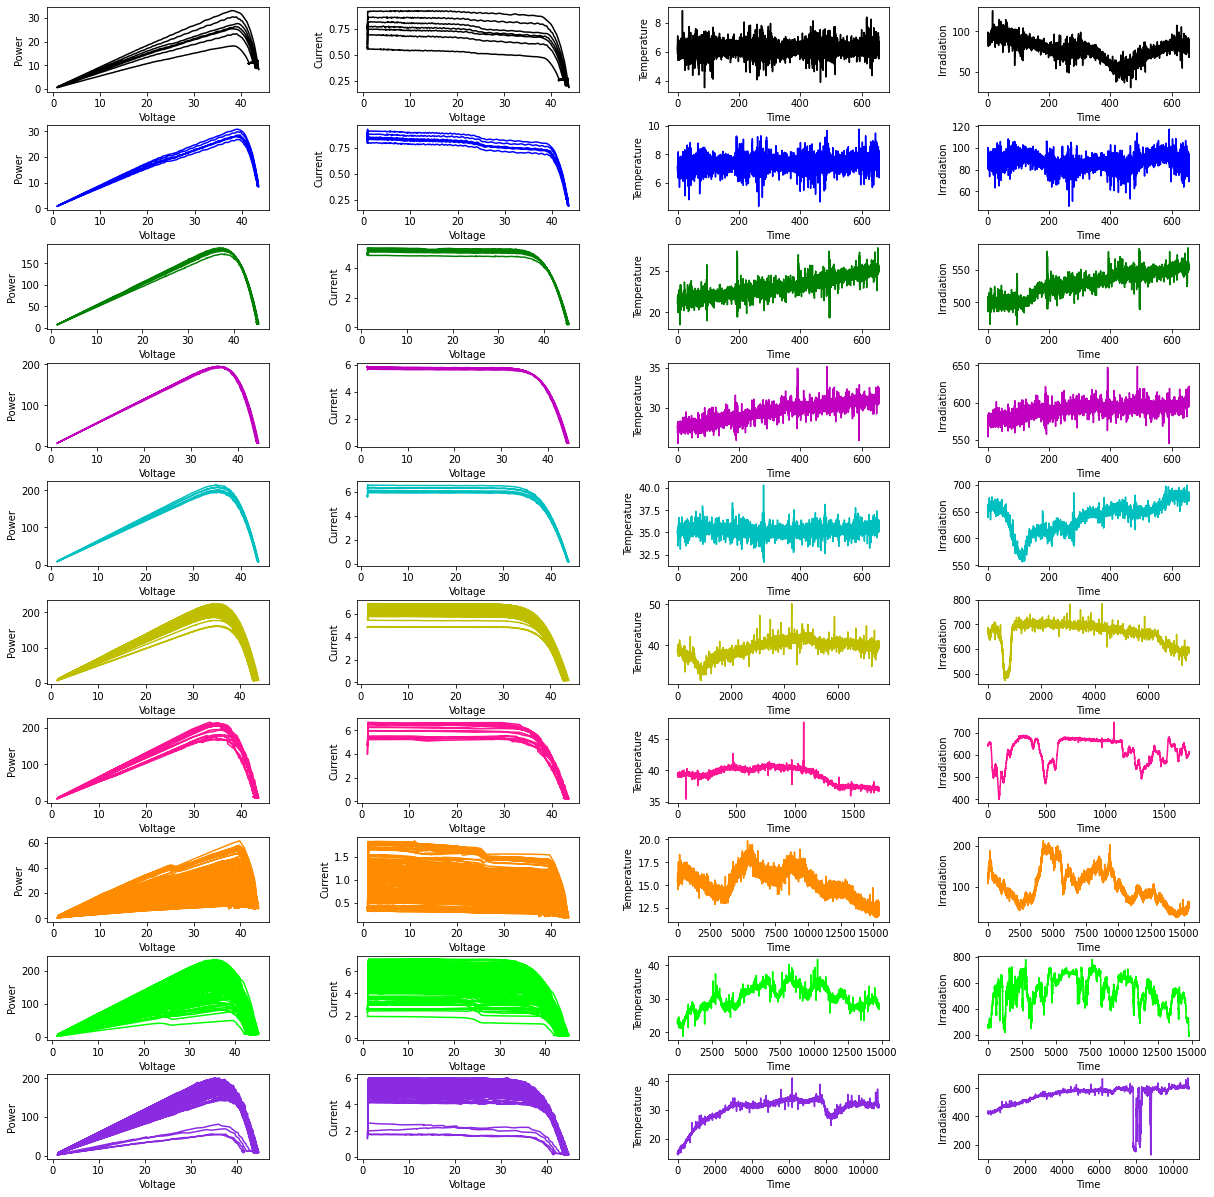

In [14]:
colors=['k','b','g','m','c','y','deeppink','darkorange','lime','blueviolet',]                
Xlab=['Voltage','Voltage','Time','Time']                                                # name of x-axis
Ylab=['Power','Current','Temperature','Irradiation']                                    # name of y-axis
nb_rows = 10  
nb_columns = 4  
plt_counter = 1  # initialize plot counter

fig = plt.figure(figsize=(20,20))

# The following adjustment is needed to make space between the figures
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

data_frame=df_replaced_rows


def subplot_data(data_frame,nb_rows,nb_columns,plt_counter,colors,X,Y,Xlab,Ylab,fig):
  itm=0
  color=0
  for i in range(nb_rows): 
    index=0 
    for j in range(nb_columns):
      plt.subplot(nb_rows, nb_columns, plt_counter)
      # plt.title('subplot: {} {} {}'.format( a, b, c))
      plt.xlabel(Xlab[index])
      plt.ylabel(Ylab[index])
      plt.plot(data_frame[X[itm]], data_frame[Y[itm]], colors[color]) #,label=k2[index]
      plt_counter = plt_counter + 1
      itm= itm + 1
      index=index+1
    color=color+1
  plt.show()

subplot_data(data_frame,nb_rows,nb_columns,plt_counter,colors,X,Y,Xlab,Ylab,fig)


## Filtring the Temperature and Irradiation signals

In [15]:


# Define the filter requirements
T = 1.0         # Sample Period
fs = 200.0       # sample rate, Hz
cutoff = 2      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples


# Filter implementation using scipy
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    F = filtfilt(b, a, data)
    return F


df_filtered = df_replaced_rows

col=df_filtered.columns
for i in range(0,len(col),6):
  data=df_filtered[col[i+1]]
  Filterd_temperature = butter_lowpass_filter(data, cutoff, fs, order)
  df_filtered[col[i+1]]=Filterd_temperature

  data=df_filtered[col[i+2]]
  Filterd_irradiation = butter_lowpass_filter(data, cutoff, fs, order)
  df_filtered[col[i+2]]=Filterd_irradiation



In [16]:
col=df_filtered.columns
X,Y= X_and_Y_axis(col)
print(X)
print(Y)

['V_PV01', 'V_PV01', 'TIME01', 'TIME01', 'V_PV02', 'V_PV02', 'TIME02', 'TIME02', 'V_PV03', 'V_PV03', 'TIME03', 'TIME03', 'V_PV04', 'V_PV04', 'TIME04', 'TIME04', 'V_PV05', 'V_PV05', 'TIME05', 'TIME05', 'V_PV06', 'V_PV06', 'TIME06', 'TIME06', 'V_PV07', 'V_PV07', 'TIME07', 'TIME07', 'V_PV08', 'V_PV08', 'TIME08', 'TIME08', 'V_PV09', 'V_PV09', 'TIME09', 'TIME09', 'V_PV10', 'V_PV10', 'TIME10', 'TIME10']
['P_PV01', 'I_PV01', 'T_PV01', 'G_PV01', 'P_PV02', 'I_PV02', 'T_PV02', 'G_PV02', 'P_PV03', 'I_PV03', 'T_PV03', 'G_PV03', 'P_PV04', 'I_PV04', 'T_PV04', 'G_PV04', 'P_PV05', 'I_PV05', 'T_PV05', 'G_PV05', 'P_PV06', 'I_PV06', 'T_PV06', 'G_PV06', 'P_PV07', 'I_PV07', 'T_PV07', 'G_PV07', 'P_PV08', 'I_PV08', 'T_PV08', 'G_PV08', 'P_PV09', 'I_PV09', 'T_PV09', 'G_PV09', 'P_PV10', 'I_PV10', 'T_PV10', 'G_PV10']


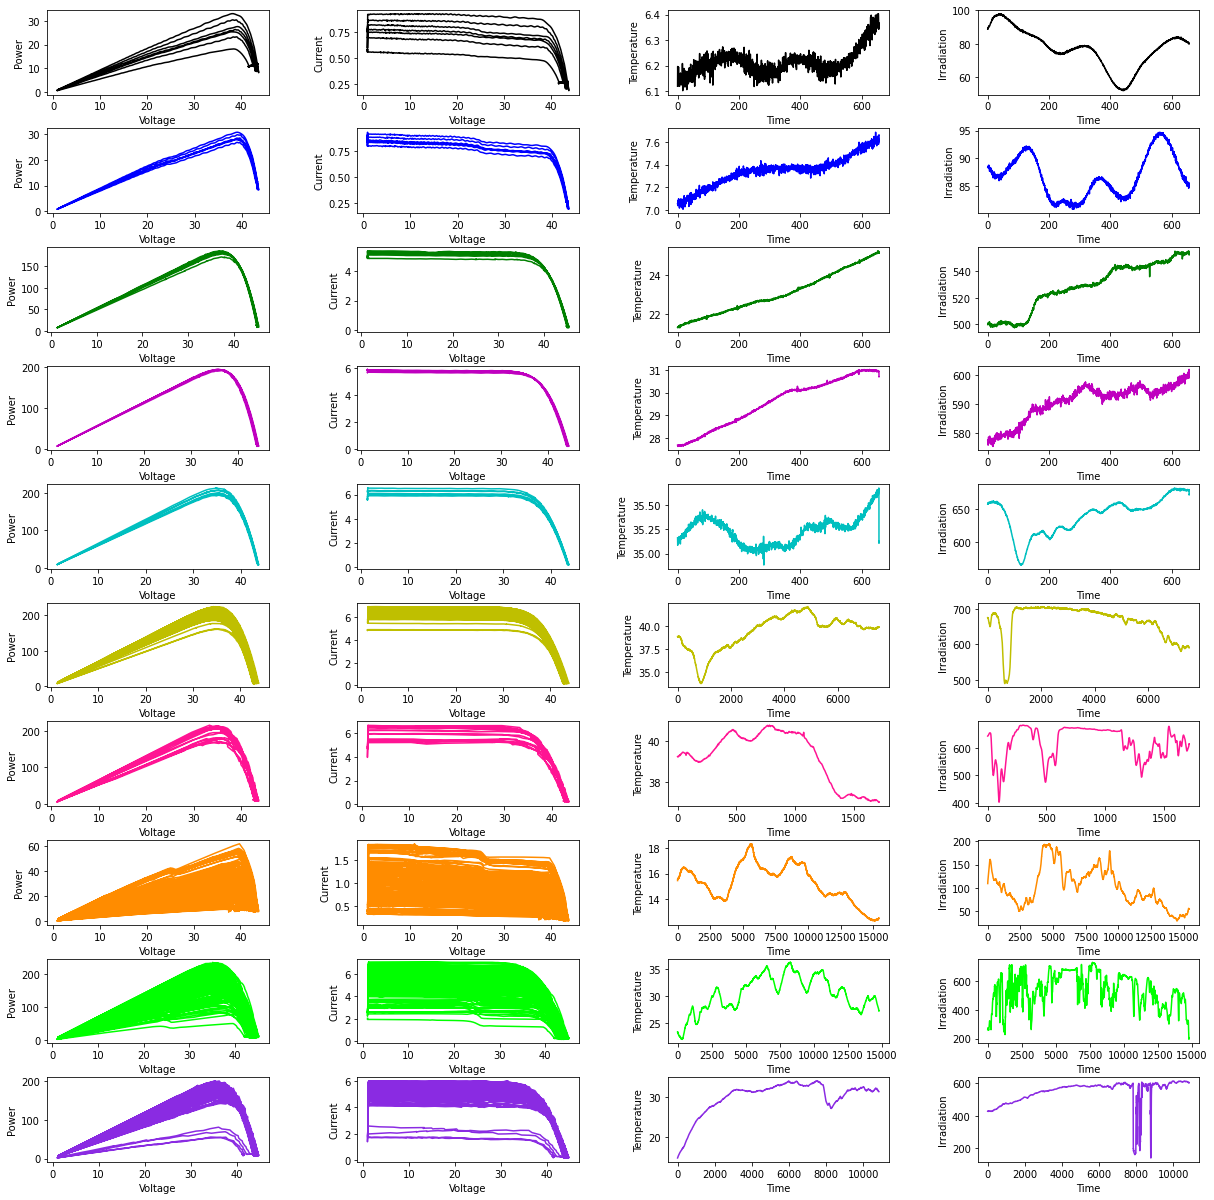

In [17]:
data_frame=df_filtered
fig = plt.figure(figsize=(20,20))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

subplot_data(data_frame,nb_rows,nb_columns,plt_counter,colors,X,Y,Xlab,Ylab,fig)

# Maximum power points

To claculate the maximum power pint for each curve, first we need to plot the power versus the time

In [18]:

# determination of x-axis and y-axis 
col=df.columns
Time=[]   
Temperature=[]
Irradiation=[]
Current=[]
Voltage=[]
Power=[]

Time_index=[]
Temperature_index=[]
Irradiation_index=[]
Current_index=[]
Voltage_index=[]
Power_index=[]

for i in range(0,len(col),6):
  index=col[i] 
  Time.append(index)
  Time_index.append(i)
  index=col[i+1] 
  Temperature.append(index)
  Temperature_index.append(i+1)
  index=col[i+2]
  Irradiation.append(index)
  Irradiation_index.append(i+2)
  index=col[i+3] 
  Current.append(index)
  Current_index.append(i+3)
  index=col[i+4] 
  Voltage.append(index)
  Voltage_index.append(i+4)
  index=col[i+5] 
  Power.append(index)
  Power_index.append(i+5)


# convert list to array
Time=np.array(Time)
Temperature=np.array(Temperature)
Irradiation=np.array(Irradiation)
Current=np.array(Current)
Voltage=np.array(Voltage)
Power=np.array(Power)

print(Time_index,'\n', Temperature_index,'\n',Irradiation_index,'\n',Current_index,'\n',Voltage_index,'\n',Power_index)
print(Time,'\n', Temperature,'\n',Irradiation,'\n',Current,'\n',Voltage,'\n',Power)

[0, 6, 12, 18, 24, 30, 36, 42, 48, 54] 
 [1, 7, 13, 19, 25, 31, 37, 43, 49, 55] 
 [2, 8, 14, 20, 26, 32, 38, 44, 50, 56] 
 [3, 9, 15, 21, 27, 33, 39, 45, 51, 57] 
 [4, 10, 16, 22, 28, 34, 40, 46, 52, 58] 
 [5, 11, 17, 23, 29, 35, 41, 47, 53, 59]
['TIME01' 'TIME02' 'TIME03' 'TIME04' 'TIME05' 'TIME06' 'TIME07' 'TIME08'
 'TIME09' 'TIME10'] 
 ['T_PV01' 'T_PV02' 'T_PV03' 'T_PV04' 'T_PV05' 'T_PV06' 'T_PV07' 'T_PV08'
 'T_PV09' 'T_PV10'] 
 ['G_PV01' 'G_PV02' 'G_PV03' 'G_PV04' 'G_PV05' 'G_PV06' 'G_PV07' 'G_PV08'
 'G_PV09' 'G_PV10'] 
 ['I_PV01' 'I_PV02' 'I_PV03' 'I_PV04' 'I_PV05' 'I_PV06' 'I_PV07' 'I_PV08'
 'I_PV09' 'I_PV10'] 
 ['V_PV01' 'V_PV02' 'V_PV03' 'V_PV04' 'V_PV05' 'V_PV06' 'V_PV07' 'V_PV08'
 'V_PV09' 'V_PV10'] 
 ['P_PV01' 'P_PV02' 'P_PV03' 'P_PV04' 'P_PV05' 'P_PV06' 'P_PV07' 'P_PV08'
 'P_PV09' 'P_PV10']


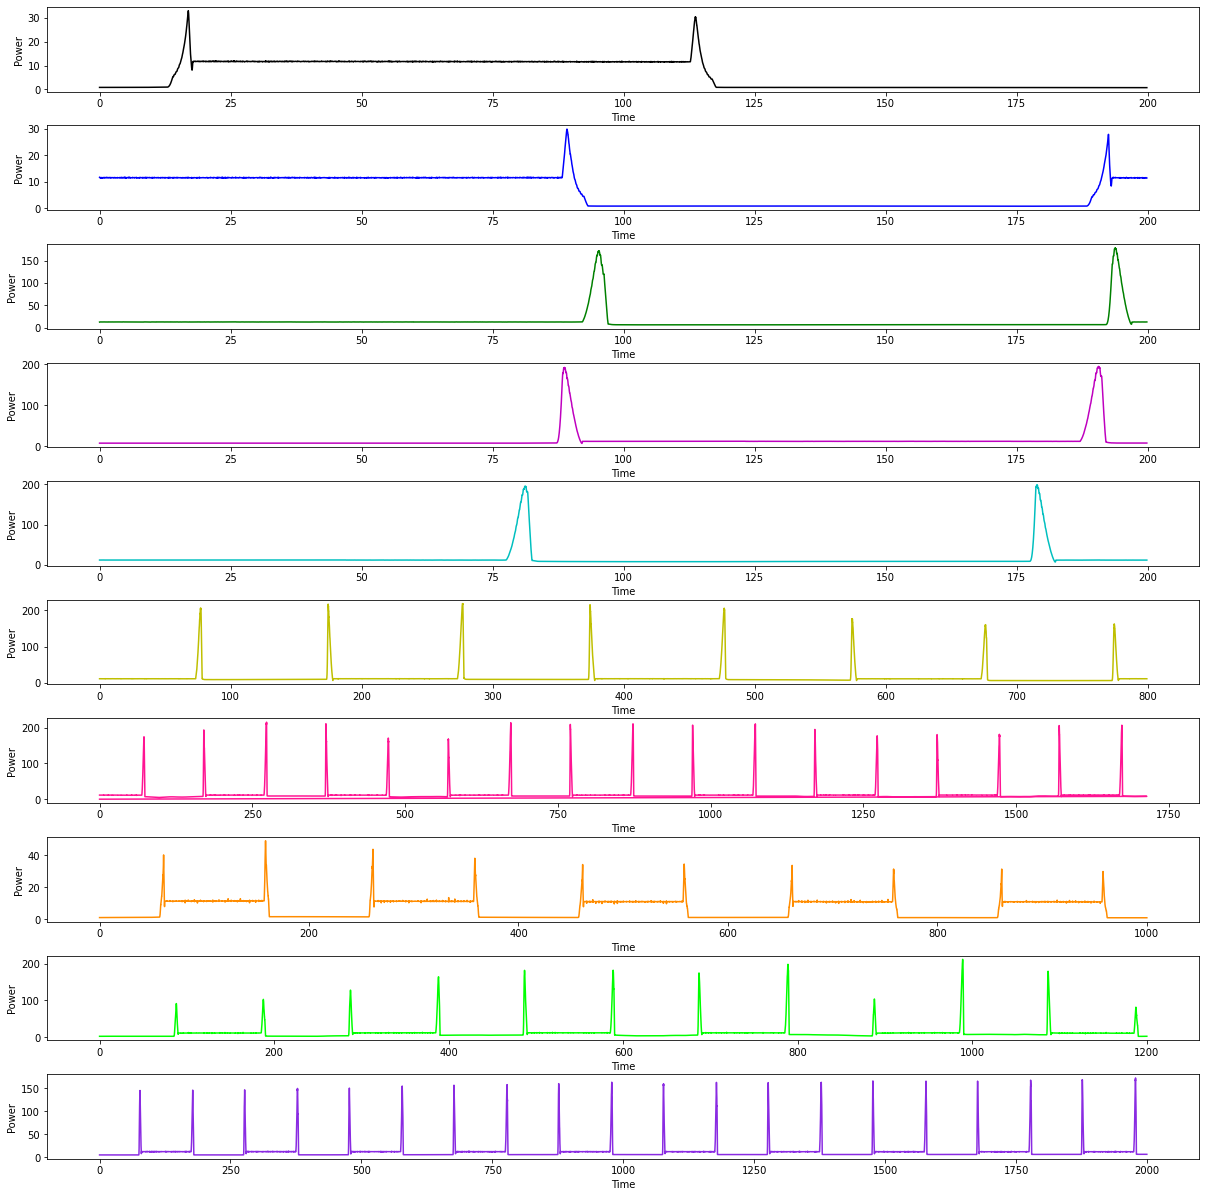

In [19]:
nb_rows = 10  
nb_columns = 1 
plt_counter = 1  # initialize plot counter

fig = plt.figure(figsize=(20,20))

# The following adjustment is needed to make space between the figures
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

# Replace NaN Values with Zeros
df0 = df.replace(np.nan, 0)

# Plot the first 20 000 rows
df_limit=df0[0:20000]

itm=0
for i in range(len(Time)): 
  plt.subplot(nb_rows, nb_columns, plt_counter)
  # plt.title('subplot: {} {} {}'.format( a, b, c))
  plt.xlabel('Time')
  plt.ylabel('Power')
  plt.plot(df_limit[Time[itm]], df_limit[Power[itm]], colors[itm]) #,label=k2[index]
  plt_counter = plt_counter + 1
  itm= itm + 1
plt.show()

We have ploted the Power Vs Time for the first 20 000 row in order to dtermine the periods used for recording. So according to the graph above, we can calculate the maximum power using the followin information:
- For the first 5 graphs we can calculate the maximum power for each 10.000 row.
- For the 6th graph we can calculate the maximum power for each 2.500 row.
- For the 7th and 10th graph we can calculate the maximum power for each 1000 row.
- For the 8th graph we can calculate the maximum power for each 2000 row.
- For the 9th graph we can calculate the maximum power for each 10.000/6 row.


In [20]:
# Extracting the maximum power points
PMAX=[]
VMAX=[]
IMAX=[]
GMAX=[]
TMAX=[]
MAX_index=[]

cursor=0
previous_max_value=0
for i in range(len(Power)):
  if cursor<5:
    step=10000
  if cursor==5:
    step=2500
  if cursor==6 or cursor==9:
    step=1000
  if cursor==7:
    step==2000
  if cursor==8:
    step=10000//6
  for j in range(0,len(df_filtered[Power[i]]),step):
    k=j
    max_value=np.max(df_filtered.iloc[k:k+step,Power_index[cursor]])
    if max_value != previous_max_value:
      PMAX.append(max_value)
      max_index = df_filtered[df_filtered[Power[i]]==max_value].index.values.astype(int)[0]
      MAX_index.append(max_index)
      IMAX.append(df_filtered.iloc[max_index,Current_index[cursor]])
      VMAX.append(df_filtered.iloc[max_index,Voltage_index[cursor]])
      GMAX.append(df_filtered.iloc[max_index,Irradiation_index[cursor]])
      TMAX.append(df_filtered.iloc[max_index,Temperature_index[cursor]])
    previous_max_value=max_value
    k1=j
  cursor=cursor+1  
print(len(PMAX),'\n')

704 



In [21]:
# Convert the lists of the maximum to Pandas Dataframe

# df_MAX = pd.DataFrame(list(zip(MAX_index, PMAX, VMAX, IMAX, GMAX, TMAX)), columns = ['MAX_index', 'PMAX', 'VMAX', 'IMAX', 'GMAX', 'TMAX'])
# df_MAX.head()
# Or we can use dictionary
dictionary = {'IMAX': IMAX, 'VMAX': VMAX, 'PMAX': PMAX,  'GMAX': GMAX, 'TMAX': TMAX} #'MAX_index': MAX_index,
df_max = pd.DataFrame(dictionary)
df_max.head()

,IMAX,VMAX,PMAX,GMAX,TMAX
0,0.868494,38.084686,33.076332,94.742025,6.102379
1,0.794872,38.304861,30.447451,87.917330,6.232654
2,0.667795,38.003550,25.378564,75.654462,6.262755
3,0.678806,38.840862,26.365400,78.384624,6.159151
4,0.471769,38.448103,18.138638,54.539170,6.201896


In [22]:
# # In case the database is connected via the method 2, then the following error will apear when plotting the 3d graph: 
# # unsupported operand type(s) for *: 'float' and 'decimal.Decimal'. To solve this error, the following code can be used:
# for col in df_max.columns:
#   df_max[col]=np.array(df_max[col], dtype=float)

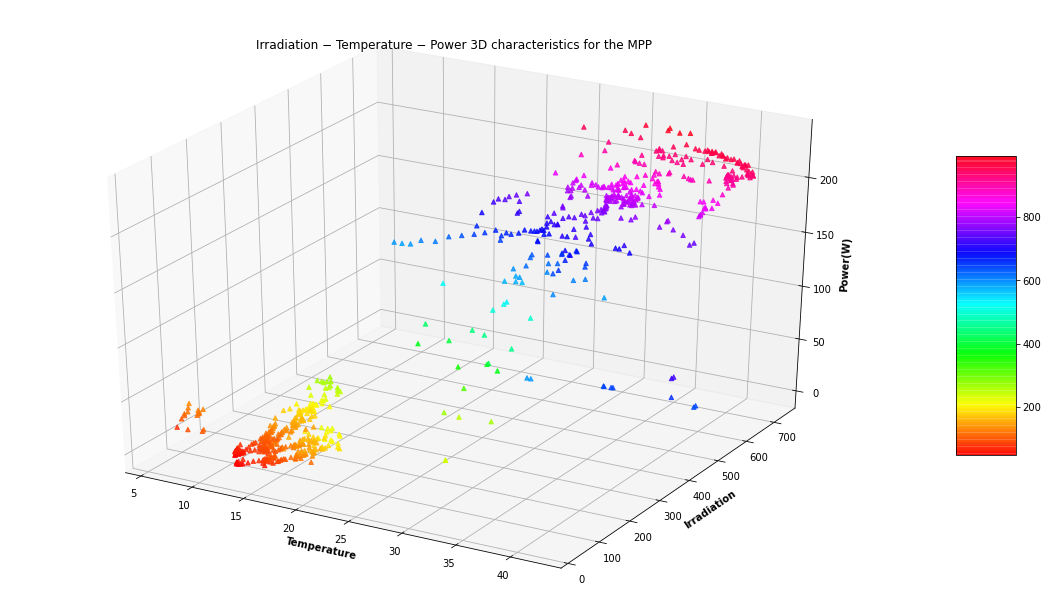

In [23]:
# Creating figure
fig = plt.figure(figsize = (20, 11))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
 
# Creating color map
my_cmap = plt.get_cmap('hsv')
 
# Creating plot
x=df_max['TMAX']
y=df_max['GMAX']
z=df_max['PMAX']

sctt = ax.scatter3D(x, y, z,
                    alpha = .8,
                    c = (x + y + z),
                    cmap = my_cmap,
                    marker ='^')
 
plt.title("Irradiation − Temperature − Power 3D characteristics for the MPP")
ax.set_xlabel('Temperature', fontweight ='bold')
ax.set_ylabel('Irradiation', fontweight ='bold')
ax.set_zlabel('Power(W)', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
 
plt.show()

#stats

##1) Correlation
 Correlation means to find out the association between the two variables and Correlation coefficients are used to find out how strong is the relationship between the two variables.

### a) *Pearson* correlation

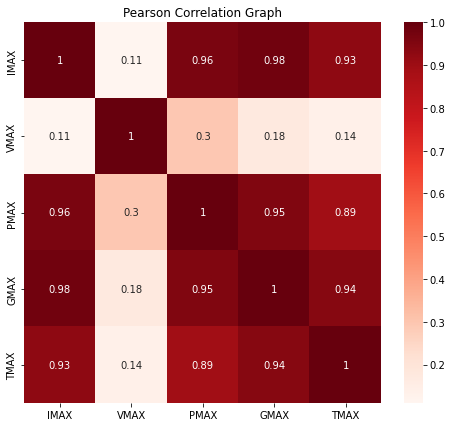

In [24]:
plt.figure(figsize=(8,7))
corr_pearson = df_max.corr(method="pearson")
sns.heatmap(corr_pearson, annot=True, cmap=plt.cm.Reds)
plt.title("Pearson Correlation Graph")
plt.show()

### b) *Spearman* correlation

**Comparison of Pearson and Spearman coefficients**
* The fundamental difference between the two correlation coefficients is that the Pearson coefficient works with a linear relationship between the two variables whereas the Spearman Coefficient works with monotonic relationships as well. 
* * A monotonic relationship is a relationship that does one of the following:  1. As the value of one variable increases, so does the value of the other variable, OR; 2. As the value of one variable increases, the other variable value decreases.

* Now, if we feel that a scatterplot is visually indicating a “might be monotonic, might be linear” relationship, our best bet would be to apply Spearman and not Pearson. No harm would be done by switching to Spearman even if the data turned out to be perfectly linear. But, if it’s not exactly linear and we use Pearson's coefficient then we’ll miss out on the information that Spearman could capture.

**NOTE: If a scatterplot indicates a relationship that cannot be expressed by a linear or monotonic function, then both of these coefficients must not be used to determine the strength of the relationship between the variables**

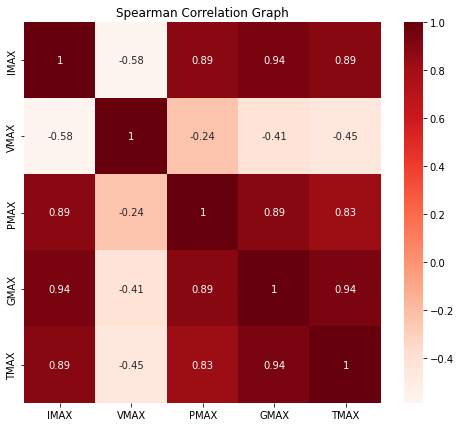

In [25]:
plt.figure(figsize=(8,7))
corr_spearman = df_max.corr(method="spearman")
sns.heatmap(corr_spearman, annot=True, cmap=plt.cm.Reds)
plt.title("Spearman Correlation Graph")
plt.show()

In [26]:
corr_spearman

,IMAX,VMAX,PMAX,GMAX,TMAX
IMAX,1.000000,-0.584593,0.887541,0.938708,0.890394
VMAX,-0.584593,1.000000,-0.236893,-0.407492,-0.452126
PMAX,0.887541,-0.236893,1.000000,0.892289,0.832835
GMAX,0.938708,-0.407492,0.892289,1.000000,0.936752
TMAX,0.890394,-0.452126,0.832835,0.936752,1.000000


In [27]:
#Correlation with output variables IMAX or VMAX

target1= corr_spearman[["VMAX"]]
# target1=target1[target1>0.5]
target1

,VMAX
IMAX,-0.584593
VMAX,1.000000
PMAX,-0.236893
GMAX,-0.407492
TMAX,-0.452126


In [28]:
target2= corr_spearman[["IMAX"]]
target2

,IMAX
IMAX,1.000000
VMAX,-0.584593
PMAX,0.887541
GMAX,0.938708
TMAX,0.890394


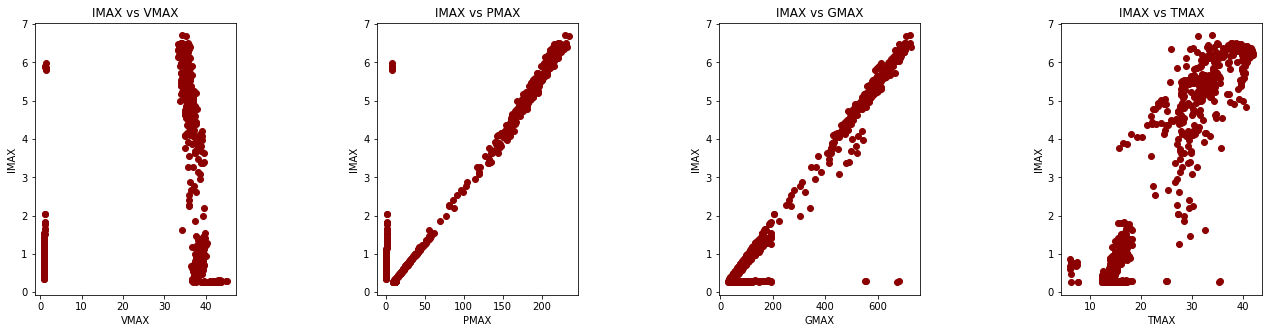

In [29]:
def plot_data_corr(df,title,color="darkred"):    
    # r = display_correlation(df)
    fig, ax = plt.subplots(nrows=1, ncols=len(df.columns)-1,figsize=(22,5))
    for i in range(1,len(df.columns)):
        ax[i-1].scatter(df.values[:,i], df["IMAX"], color=color)
        ax[i-1].title.set_text(title[i-1])
        ax[i-1].set(xlabel=df.columns[i],ylabel=df.columns[0])
    fig.subplots_adjust(wspace=.7)    
    plt.show()

plot_data_corr(df_max,["IMAX vs VMAX","IMAX vs PMAX","IMAX vs GMAX","IMAX vs TMAX"])

In [30]:
# loading data into spark dataFrame
sdf_max = spark.createDataFrame(df_max)
sdf_max.show(5)


+-----------+-----------+-----------+------------------+-----------------+
|       IMAX|       VMAX|       PMAX|              GMAX|             TMAX|
+-----------+-----------+-----------+------------------+-----------------+
|0.868494273|38.08468646|33.07633206| 94.74202509856494|6.102379133658507|
|0.794871716|38.30486147|30.44745098| 87.91733043126995|6.232654305998735|
|0.667794556|38.00355043|25.37856409| 75.65446192018234|6.262755346460471|
| 0.67880574|38.84086158| 26.3653998| 78.38462406808368|6.159151151460771|
|0.471769384|38.44810318|18.13863796|54.539169606932056|6.201895524493021|
+-----------+-----------+-----------+------------------+-----------------+
only showing top 5 rows



In [31]:
# Drop unnecessary columns (selecting highly correlated features)
sdf_max_dataset=sdf_max.drop('TMAX', 'VMAX')
sdf_max_dataset.show(5)

+-----------+-----------+------------------+
|       IMAX|       PMAX|              GMAX|
+-----------+-----------+------------------+
|0.868494273|33.07633206| 94.74202509856494|
|0.794871716|30.44745098| 87.91733043126995|
|0.667794556|25.37856409| 75.65446192018234|
| 0.67880574| 26.3653998| 78.38462406808368|
|0.471769384|18.13863796|54.539169606932056|
+-----------+-----------+------------------+
only showing top 5 rows



In [32]:
#Converting data frame columns into feature vectors
required_features=['PMAX', 'GMAX']

assembler = VectorAssembler(
    inputCols=required_features,
    outputCol="Features")

transformed_data = assembler.transform(sdf_max_dataset).select('Features','IMAX')
transformed_data.show(5)

+--------------------+-----------+
|            Features|       IMAX|
+--------------------+-----------+
|[33.07633206,94.7...|0.868494273|
|[30.44745098,87.9...|0.794871716|
|[25.37856409,75.6...|0.667794556|
|[26.3653998,78.38...| 0.67880574|
|[18.13863796,54.5...|0.471769384|
+--------------------+-----------+
only showing top 5 rows



In [33]:
# Split
training_data, test_data = transformed_data.randomSplit([0.8, 0.2])

print('trianing data:', (training_data.count(), len(training_data.columns)))
print('test data: ', (test_data.count(), len(test_data.columns)))

# Shuffle dataset: 
training_data_shuffled = training_data.orderBy(rand())
print('shuffled data:')
training_data_shuffled.show(5)
#shuffle helps the training to converge fast. it prevents any bias during the training. it prevents the model from learning the order of the training.

trianing data: (565, 2)
test data:  (139, 2)
shuffled data:
+--------------------+-----------+
|            Features|       IMAX|
+--------------------+-----------+
|[132.724619,478.0...| 3.37246443|
|[189.9725531,581....|5.423141484|
|[204.2302014,626....| 5.85691236|
|[52.05504613,175....|1.290883305|
|[199.3420576,634....| 5.90437655|
+--------------------+-----------+
only showing top 5 rows




##2) Normalization & Standardization


* Standardization and normalization are two ways to rescale data.
* Normalization is used when the data doesn't have Gaussian (Normal) distribution whereas Standardization is used on data having Gaussian distribution.
* Normalization scales in a range of [0,1] or [-1,1]. Standardization is not bounded by range.




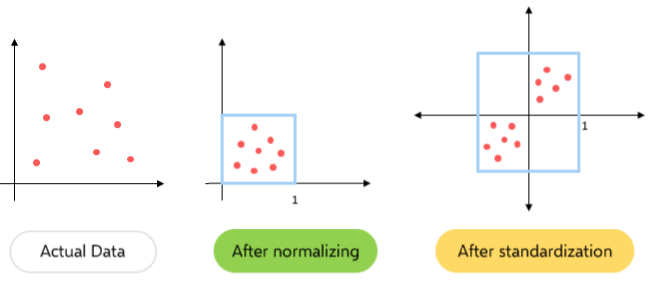

### Normalization
* Normalization rescales a dataset so that each value falls between 0 and 1. It uses the following formula to do so:

xnew = (xi – xmin) / (xmax – xmin)

* Normalizing the data generally speeds up learning and leads to faster convergence.

* If x is the vector of covariates of length n, and say that the normalized vector is y=x/z then the three options denote what to use for z:

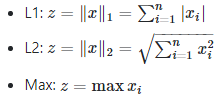

In [34]:
normalizer = Normalizer(inputCol="Features", outputCol="Features_normalized", p=1.0)
training_norm1 = normalizer.transform(training_data_shuffled)
print("Normalized using L^1 norm")
training_norm1.show(5, truncate=False)

Normalized using L^1 norm
+--------------------------------+-----------+----------------------------------------+
|Features                        |IMAX       |Features_normalized                     |
+--------------------------------+-----------+----------------------------------------+
|[132.724619,478.0265097838662]  |3.37246443 |[0.21731375145271134,0.7826862485472886]|
|[189.9725531,581.2893853453222] |5.423141484|[0.24631392219735201,0.753686077802648] |
|[204.2302014,626.0979822733993] |5.85691236 |[0.2459632292577121,0.7540367707422879] |
|[52.05504613,175.97489322778532]|1.290883305|[0.22828162949394196,0.7717183705060581]|
|[199.3420576,634.6198384915062] |5.90437655 |[0.23903017456102965,0.7609698254389704]|
+--------------------------------+-----------+----------------------------------------+
only showing top 5 rows



In [35]:
normalizer = Normalizer(inputCol="Features", outputCol="Features_normalized", p=2.0)
training_norm2 = normalizer.transform(training_data_shuffled)
print("Normalized using L^2 norm")
training_norm2.show(5, truncate=False)

Normalized using L^2 norm
+--------------------------------+-----------+----------------------------------------+
|Features                        |IMAX       |Features_normalized                     |
+--------------------------------+-----------+----------------------------------------+
|[132.724619,478.0265097838662]  |3.37246443 |[0.2675306064651783,0.9635493628270292] |
|[189.9725531,581.2893853453222] |5.423141484|[0.31064377307417795,0.9505264048148472]|
|[204.2302014,626.0979822733993] |5.85691236 |[0.3101136762459606,0.9506994834358624] |
|[52.05504613,175.97489322778532]|1.290883305|[0.2836591785301468,0.9589251641476526] |
|[199.3420576,634.6198384915062] |5.90437655 |[0.2996762410684612,0.9540409585227866] |
+--------------------------------+-----------+----------------------------------------+
only showing top 5 rows



In [36]:
Scaler = MinMaxScaler(inputCol="Features", outputCol="Features_normalized")

# Compute summary statistics and generate MinMaxScalerModel
scalerModel = Scaler.fit(training_data_shuffled)

# rescale each feature to range [min, max].
training_norm3 = scalerModel.transform(training_data_shuffled)

print("Features scaled to range: [%f, %f]" % (Scaler.getMin(), Scaler.getMax()))
training_norm3.show(5, truncate=False)
# scaledData.select("features", "scaledFeatures").show()

Features scaled to range: [0.000000, 1.000000]
+--------------------------------+-----------+---------------------------------------+
|Features                        |IMAX       |Features_normalized                    |
+--------------------------------+-----------+---------------------------------------+
|[132.724619,478.0265097838662]  |3.37246443 |[0.5648524272869327,0.6442668118171285]|
|[189.9725531,581.2893853453222] |5.423141484|[0.8090500507940874,0.7924419382379562]|
|[204.2302014,626.0979822733993] |5.85691236 |[0.869867683541831,0.8567391939405274] |
|[52.05504613,175.97489322778532]|1.290883305|[0.2207471194904854,0.2108435101178052]|
|[199.3420576,634.6198384915062] |5.90437655 |[0.8490167459824749,0.8689674716791869]|
+--------------------------------+-----------+---------------------------------------+
only showing top 5 rows



**Note:** For regression problems we don't normally normalize the outputs if it is a one demention. However this is not the case for the multiregression values. 

### Standardization

* Standardization rescales a dataset to have a mean of 0 and a standard deviation of 1. It uses the following formula to do so:

xnew = (xi – x) / s

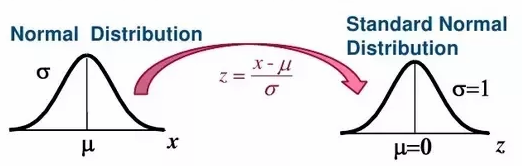

In [40]:
standard_scaler = StandardScaler(inputCol="Features", outputCol="Features_standardized")
training_stand = standard_scaler.fit(training_data_shuffled)
training_scaled = training_stand.transform(training_data_shuffled)
training_scaled.show(5, truncate=False)

+--------------------------------+-----------+---------------------------------------+
|Features                        |IMAX       |Features_standardized                  |
+--------------------------------+-----------+---------------------------------------+
|[132.724619,478.0265097838662]  |3.37246443 |[1.5254358492716626,1.9097566710623877]|
|[189.9725531,581.2893853453222] |5.423141484|[2.183400073473969,2.32230066483742]   |
|[204.2302014,626.0979822733993] |5.85691236 |[2.347266641763965,2.5013148306899207] |
|[52.05504613,175.97489322778532]|1.290883305|[0.5982811184577003,0.7030347049857213]|
|[199.3420576,634.6198384915062] |5.90437655 |[2.2910860337871206,2.5353603729961884]|
+--------------------------------+-----------+---------------------------------------+
only showing top 5 rows



# Modeling

In [41]:
# from pyspark.ml.classification import RandomForestClassifier
# rf = RandomForestClassifier(labelCol='Survived', 
#                             featuresCol='features',
#                             maxDepth=5)

# model = rf.fit(training_data)

# predictions = model.transform(test_data)


# Evaluate our model
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# evaluator = MulticlassClassificationEvaluator(
#     labelCol='Survived', 
#     predictionCol='prediction', 
#     metricName='accuracy')

# accuracy = evaluator.evaluate(predictions)
# print('Test Accuracy = ', accuracy) -> 0.843







#upload data from local machine

# uploaded = files.upload()  
# data= io.BytesIO(uploaded['PV_all_data.xlsx'])
# df = pd.read_excel(data)

# upload Excel data from git
# url = 'https://github.com/Mohamed-derbeli/ML-for-maximum-power-point-tracking-prediction-in-PV-system/blob/main/PV_data.xlsx?raw=true'





# 2D
# df.plot(x ='Vmax', y='Pmax', kind = 'scatter')	
# df.plot(x ='Vmax', y='Imax', kind = 'scatter')	